In [3]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df


In [4]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


# Example usage:
animals = ['PV_62','PV_126', 'PV_57']
block_lists = [[23,24,26,38],[7,8,9,10,11,12,13],[7,8,9,10,11,12,13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!
instantiated block number 038 at Path: Z:\Nimrod\experi

In [5]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
Getting eye brightness values for block 023...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
Getting eye brightness values for block 024...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
Getting eye brightness values for block 026...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

c:\users\marks3\pycharmprojects\pythonproject3\venv\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 011 has a parsed events file, reading...
Getting eye brightness values for block 011...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 012 has a parsed events file, reading...
Getting eye brightness values for block 012...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 013 has a parsed events file, reading...
Getting eye brightness values for block 013...
Found an existing 

In [6]:
def create_saccade_events_df(
    eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True
):
    """
    Detects saccade events in eye tracking data and computes relevant metrics, ensuring only valid saccades are included.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.
    """
    df = eye_data_df.copy()
    df["speed_x"] = df["center_x"].diff()  # Difference between consecutive 'center_x' values
    df["speed_y"] = df["center_y"].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df["speed_r"] = (df["speed_x"]**2 + df["speed_y"]**2)**0.5

    # Create a column for saccade detection
    df["is_saccade"] = df["speed_r"] > speed_threshold

    # Identify saccade onset and offset indices
    saccade_on_off = df["is_saccade"].astype(int) - df["is_saccade"].shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1  # Include frame before threshold crossing
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle cases where the last saccade has no end
    if len(saccade_on_inds) > len(saccade_off_inds):
        if len(saccade_on_inds) - len(saccade_off_inds) == 1:
            print("Detected unmatched final saccade start index. Truncating last saccade start index.")
            saccade_on_inds = saccade_on_inds[:-1]
        else:
            raise ValueError("Mismatch between saccade start and end indices. Manual inspection required.")

    # Extract timestamps and indices
    saccade_dict = {
        "saccade_start_ind": saccade_on_inds,
        "saccade_start_timestamp": df["OE_timestamp"].iloc[saccade_on_inds].values,
        "saccade_end_ind": saccade_off_inds,
        "saccade_end_timestamp": df["OE_timestamp"].iloc[saccade_off_inds].values,
        "saccade_on_ms": df["ms_axis"].iloc[saccade_on_inds].values,
        "saccade_off_ms": df["ms_axis"].iloc[saccade_off_inds].values,
    }

    # Ensure all lists have consistent lengths
    valid_mask = np.all(
        [
            len(saccade_dict[field]) == len(saccade_dict["saccade_start_ind"])
            for field in saccade_dict
        ]
    )
    if not valid_mask:
        valid_lengths = {
            key: len(value) for key, value in saccade_dict.items()
        }
        print(f"Detected inconsistent lengths in saccade fields: {valid_lengths}")
        raise ValueError("Fields in saccade dictionary must all have equal lengths.")

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df["length"] = saccade_events_df["saccade_end_ind"] - saccade_events_df["saccade_start_ind"]

    # Compute saccade metrics
    distances = []
    angles = []
    speed_list = []
    diameter_list = []

    for _, row in tqdm.tqdm(saccade_events_df.iterrows(), total=len(saccade_events_df)):
        saccade_samples = df.loc[
            (df["OE_timestamp"] >= row["saccade_start_timestamp"])
            & (df["OE_timestamp"] <= row["saccade_end_timestamp"])
        ]
        if saccade_samples.empty:
            continue

        # Distance traveled
        distance_traveled = saccade_samples["speed_r"].sum()
        distances.append(distance_traveled)

        # Speed profile
        if speed_profile:
            saccade_speed_profile = saccade_samples["speed_r"].values
            speed_list.append(saccade_speed_profile)

        # Diameter profile
        saccade_diameter_profile = saccade_samples["pupil_diameter"].values
        diameter_list.append(saccade_diameter_profile)

        # Calculate angle
        initial_position = saccade_samples.iloc[0][["center_x", "center_y"]]
        endpoint = saccade_samples.iloc[-1][["center_x", "center_y"]]
        overall_angle = np.arctan2(
            endpoint["center_y"] - initial_position["center_y"],
            endpoint["center_x"] - initial_position["center_x"]
        )
        angles.append(overall_angle)

    # Add metrics to DataFrame
    saccade_events_df["magnitude_raw"] = np.array(distances)
    saccade_events_df["magnitude"] = np.array(distances) * magnitude_calib
    saccade_events_df["angle"] = np.rad2deg(angles) % 360  # Convert radians to degrees
    saccade_events_df["speed_profile"] = speed_list
    saccade_events_df["diameter_profile"] = diameter_list

    # Remove intermediate columns from df
    df = df.drop(["is_saccade"], axis=1)

    return df, saccade_events_df


In [7]:
# saccade detection and annotation: 
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.L_pix_size)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.R_pix_size)


 11%|█         | 64/602 [00:00<00:00, 635.15it/s]

PV_62, block 023, on 2023-04-27_10-52-42


 11%|█▏        | 69/602 [00:00<00:00, 684.82it/s]

PV_62, block 024, on 2023-04-27_11-22-56


 12%|█▏        | 69/598 [00:00<00:00, 684.21it/s]

PV_62, block 026, on 2023-04-27_12-21-41


  6%|▌         | 62/1126 [00:00<00:01, 613.80it/s]

PV_62, block 038, on 2023-05-01_13-57-45


  6%|▌         | 68/1209 [00:00<00:01, 666.65it/s]

PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


 17%|█▋        | 61/366 [00:00<00:00, 607.24it/s]

PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41


 18%|█▊        | 65/359 [00:00<00:00, 640.57it/s]

PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15


 27%|██▋       | 65/245 [00:00<00:00, 648.59it/s]

PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57


  7%|▋         | 67/1009 [00:00<00:01, 666.61it/s]

PV_126, block 011, on PV126_Trial115_eyeTracking_w7


  0%|          | 0/129 [00:00<?, ?it/s]

PV_126, block 012, on PV126_Trial116_eyeTracking_h8


  0%|          | 0/77 [00:00<?, ?it/s]

PV_126, block 013, on PV126_Trial116_eyeTracking_h9


 22%|██▏       | 148/672 [00:00<00:00, 740.15it/s]

PV_57, block 007, on pv_57_day2_03_2024-11-25_15-28-31


 11%|█▏        | 73/638 [00:00<00:00, 729.20it/s]

PV_57, block 008, on pv_57_day2_05_2024-11-25_16-07-18


 15%|█▍        | 74/502 [00:00<00:00, 736.84it/s]

PV_57, block 009, on pv_57_day2_06_2024-11-25_16-25-35


 42%|████▏     | 147/352 [00:00<00:00, 734.48it/s]

PV_57, block 010, on PV_57_hunter__2024-12-01_15-37-36


 16%|█▌        | 150/954 [00:00<00:01, 743.38it/s]

PV_57, block 011, on PV_57_hunter_2_2024-12-01_15-43-28
Detected unmatched final saccade start index. Truncating last saccade start index.


 12%|█▏        | 73/589 [00:00<00:00, 723.38it/s]

PV_57, block 012, on PV_57_hunter_2_2024-12-01_16-08-39


 10%|▉         | 72/737 [00:00<00:00, 715.20it/s]

PV_57, block 013, on PV_57_hunter_2_2024-12-01_16-34-43


100%|██████████| 725/725 [00:00<00:00, 749.72it/s]


In [8]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [9]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [10]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])
    
    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')
        
    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


577it [00:00, 7309.40it/s]
577it [00:00, 7139.97it/s]
0it [00:00, ?it/s]

199 568
199 568


575it [00:00, 7197.29it/s]
1034it [00:00, 6237.14it/s]


190 547


1163it [00:00, 6836.12it/s]

599 1064



341it [00:00, 7090.24it/s]
338it [00:00, 7004.29it/s]

342 1110
181 386
204 414


230it [00:00, 7004.72it/s]
961it [00:00, 6819.46it/s]


129 273



107it [00:00, 7150.90it/s]
77it [00:00, 6911.07it/s]
669it [00:00, 8046.77it/s]

366 988
50 123
19 75
got them all



630it [00:00, 7721.22it/s]
0it [00:00, ?it/s]

322 648
209 563


489it [00:00, 7930.52it/s]
348it [00:00, 7343.32it/s]
0it [00:00, ?it/s]

271 510
157 390


926it [00:00, 5306.87it/s]
581it [00:00, 7789.48it/s]
0it [00:00, ?it/s]

337 868
144 463


706it [00:00, 7127.88it/s]


280 694


In [11]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


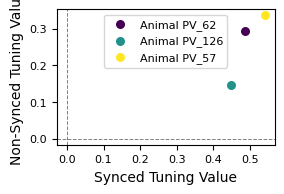

{'PV_62': (0.4856070087609512, 0.2933673469387754),
 'PV_126': (0.44865579550462753, 0.1469405984814649),
 'PV_57': (0.5399373531714957, 0.33598862019914644)}

In [12]:
import numpy as np
import matplotlib.pyplot as plt
def calculate_orientation_tuning(saccade_angles):
    """
    Calculates the orientation tuning statistic for a collection of saccade angles.

    Parameters:
        saccade_angles (array-like): List or array of saccade angles in degrees.

    Returns:
        float: Orientation tuning statistic.
    """
    # Convert angles to range [0, 360] if they aren't already
    saccade_angles = np.array(saccade_angles) % 360
    
    # Define horizontal saccade ranges
    horizontal_ranges = [
        (315, 360),  # 330° to 0°
        (0, 45),     # 0° to 30°
        (135, 225)   # 150° to 210°
    ]
    
    # Identify horizontal saccades
    is_horizontal = np.logical_or.reduce([
        (saccade_angles >= low) & (saccade_angles <= high)
        if low < high else
        (saccade_angles >= low) | (saccade_angles <= high)
        for low, high in horizontal_ranges
    ])
    
    # Calculate probabilities
    p_horizontal = np.sum(is_horizontal) / len(saccade_angles)
    p_vertical = 1 - p_horizontal  # Vertical saccades are the complement
    
    # Calculate orientation tuning
    tuning_statistic = (p_horizontal - p_vertical) / (p_horizontal + p_vertical)
    
    return tuning_statistic
def analyze_orientation_tuning(synced_df, non_synced_df):
    """
    Analyze orientation tuning for each unique animal in the given dataframes.

    Parameters:
        synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for synchronized saccades.
        non_synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for non-synchronized saccades.

    Returns:
        dict: Dictionary with animal IDs as keys and a tuple of (synced_tuning, non_synced_tuning) as values.
    """
    # Initialize dictionary to store results
    tuning_results = {}

    # Get unique animals
    unique_animals = synced_df['animal'].unique()

    for animal in unique_animals:
        # Filter data for the current animal
        synced_angles = synced_df.query('animal == @animal')['angle'].values
        non_synced_angles = non_synced_df.query('animal == @animal')['angle'].values

        # Calculate orientation tuning
        synced_tuning = calculate_orientation_tuning(synced_angles)
        non_synced_tuning = calculate_orientation_tuning(non_synced_angles)

        # Save to dictionary
        tuning_results[animal] = (synced_tuning, non_synced_tuning)

    # Plot results
    fig, ax = plt.subplots(figsize=(3, 2))

    synced_tuning_values = [v[0] for v in tuning_results.values()]
    non_synced_tuning_values = [v[1] for v in tuning_results.values()]
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_animals)))  # Generate unique colors

    for i, animal in enumerate(unique_animals):
        ax.scatter(
            synced_tuning_values[i],
            non_synced_tuning_values[i],
            color=colors[i],
            label=f"Animal {animal}",
            s=30  # Marker size
        )

    # Formatting
    ax.set_xlabel("Synced Tuning Value", fontsize=10)
    ax.set_ylabel("Non-Synced Tuning Value", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_aspect('equal', adjustable='box')  # Equal axes
    ax.legend(fontsize=8, loc='best')
    ax.grid(False)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)

    plt.tight_layout()
    plt.show()

    return tuning_results
analyze_orientation_tuning(synced_saccade_collection,non_synced_saccade_collection)

Exported plot to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning\2025_01_05_02_09_horizontal_tuning_per_animal\2025_01_05_02_09_horizontal_tuning_per_animal.pdf
Exported data to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning\2025_01_05_02_09_horizontal_tuning_per_animal\2025_01_05_02_09_saccade_angles_data.pkl


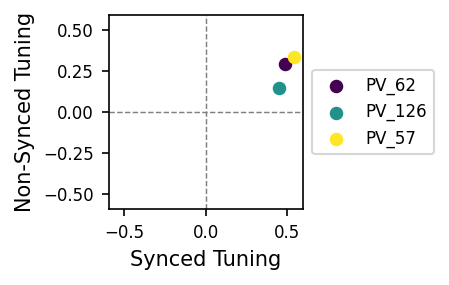

{'PV_62': (0.4856070087609512, 0.2933673469387754),
 'PV_126': (0.44865579550462753, 0.1469405984814649),
 'PV_57': (0.5399373531714957, 0.33598862019914644)}

In [73]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_orientation_tuning(synced_df, non_synced_df, export_path=None):
    """
    Analyze orientation tuning for each unique animal in the given dataframes.

    Parameters:
        synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for synchronized saccades.
        non_synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for non-synchronized saccades.

    Returns:
        dict: Dictionary with animal IDs as keys and a tuple of (synced_tuning, non_synced_tuning) as values.
    """
    # Initialize dictionary to store results
    tuning_results = {}

    # Get unique animals
    unique_animals = synced_df['animal'].unique()

    for animal in unique_animals:
        # Filter data for the current animal
        synced_angles = synced_df.query('animal == @animal')['angle'].values
        non_synced_angles = non_synced_df.query('animal == @animal')['angle'].values

        # Calculate orientation tuning
        synced_tuning = calculate_orientation_tuning(synced_angles)
        non_synced_tuning = calculate_orientation_tuning(non_synced_angles)

        # Save to dictionary
        tuning_results[animal] = (synced_tuning, non_synced_tuning)

    # Plot results
    fig, ax = plt.subplots(figsize=(5, 2), dpi=150)

    synced_tuning_values = [v[0] for v in tuning_results.values()]
    non_synced_tuning_values = [v[1] for v in tuning_results.values()]
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_animals)))  # Generate unique colors

    for i, animal in enumerate(unique_animals):
        ax.scatter(
            synced_tuning_values[i],
            non_synced_tuning_values[i],
            color=colors[i],
            label=f"{animal}",
            s=30  # Marker size
        )

    # Formatting
    ax.set_xlabel("Synced Tuning", fontsize=10)
    ax.set_ylabel("Non-Synced Tuning", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_aspect('equal')  # Ensure equal scaling
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)
    
    # Adjust axes limits to make sure x and y scales are identical
    all_values = synced_tuning_values + non_synced_tuning_values
    axis_limit = max(abs(min(all_values)), abs(max(all_values))) * 1.1
    ax.set_xlim(-axis_limit, axis_limit)
    ax.set_ylim(-axis_limit, axis_limit)

    # Move legend outside the plot
    ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)
    
    plt.tight_layout()
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_horizontal_tuning_per_animal'
        export_dir.mkdir(parents=True, exist_ok=True)
        
        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_horizontal_tuning_per_animal.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported plot to {export_file_pdf}")
        
        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")
    plt.show()

    return tuning_results

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning'
analyze_orientation_tuning(synced_saccade_collection,non_synced_saccade_collection,export_path=export_path)

In [68]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal(saccade_collection, figure_size=(8, 4), export_path=None):
    # Extract unique animals
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    # Set up the polar plots
    fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=150, subplot_kw=dict(projection='polar'))
    colors = plt.cm.viridis(np.linspace(0, 0.5, len(animals)))  # Unique colors for each animal

    # Iterate through each animal
    for color, animal in zip(colors, animals):
        # Filter saccades for the current animal
        animal_saccades = saccade_collection.query('animal == @animal')

        # Process right eye
        saccade_angles_r = animal_saccades.query('eye == "R"')['angle']
        hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360), density=True)
        bin_centers_r = list((bin_edges_r[:-1] + bin_edges_r[1:]) / 2)
        # Close the circular plot
        bin_centers_r.append(bin_centers_r[0])
        hist_r = np.append(hist_r, hist_r[0])
        axs[0].plot(
            np.deg2rad(bin_centers_r), hist_r,
            label=f'{animal} saccades)',
            color=color
        )

        # Process left eye
        saccade_angles_l = animal_saccades.query('eye == "L"')['angle']
        hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360), density=True)
        bin_centers_l = list((bin_edges_l[:-1] + bin_edges_l[1:]) / 2)
        # Close the circular plot
        bin_centers_l.append(bin_centers_l[0])
        hist_l = np.append(hist_l, hist_l[0])
        axs[1].plot(
            np.deg2rad(bin_centers_l), hist_l,
            label=f'{animal}',
            color=color
        )

    # Add shaded areas for probability = 0.1
    for ax in axs:
        theta = np.linspace(0, 2 * np.pi, 500)
        ax.fill_between(theta, 0, 0.005, color='gray', alpha=0.2, zorder=0, label='0.005 Prob.')
        
    # Format plots
    for ax, title in zip(axs, ['Right Eye', 'Left Eye']):
        if title == 'Left Eye':
            ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=6)
        else:
            ax.legend().remove()  # Remove legend for the right eye plot
        ax.grid(False)
        ax.set_yticks([])
        # Set font size for polar tick markers
        ax.tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()

    # Save the figure if export_path is provided
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_MultiAnimal_Saccade_Histogram'
        export_dir.mkdir(parents=True, exist_ok=True)
        
        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_saccade_angles_histogram.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported histogram to {export_file_pdf}")
        
        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")
    plt.tight_layout()
    plt.show()


Exported histogram to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal\2025_01_05_01_22_MultiAnimal_Saccade_Histogram\2025_01_05_01_22_saccade_angles_histogram.pdf
Exported data to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal\2025_01_05_01_22_MultiAnimal_Saccade_Histogram\2025_01_05_01_22_saccade_angles_data.pkl


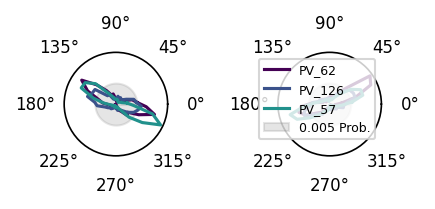

In [70]:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal')
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (3,2),export_path=export_path)

Exported histogram to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\non_synced_saccade_polar_multi_animal\2025_01_05_01_26_MultiAnimal_Saccade_Histogram\2025_01_05_01_26_saccade_angles_histogram.pdf
Exported data to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\non_synced_saccade_polar_multi_animal\2025_01_05_01_26_MultiAnimal_Saccade_Histogram\2025_01_05_01_26_saccade_angles_data.pkl


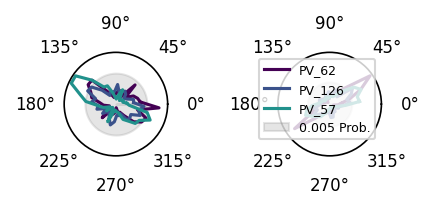

In [71]:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\non_synced_saccade_polar_multi_animal')
create_saccade_polar_histogram_multianimal(non_synced_saccade_collection, (3,2),export_path=export_path)


In [32]:
block_dict.keys()

dict_keys(['PV_62_block_023', 'PV_62_block_024', 'PV_62_block_026', 'PV_62_block_038', 'PV_126_block_007', 'PV_126_block_008', 'PV_126_block_009', 'PV_126_block_010', 'PV_126_block_011', 'PV_126_block_012', 'PV_126_block_013', 'PV_57_block_010', 'PV_57_block_011', 'PV_57_block_012'])

In [35]:
left_eye_folder = pathlib.Path(block.l_e_path)
right_eye_folder = pathlib.Path(block.r_e_path)


In [38]:
# Define the left and right eye folders
left_eye_folder = pathlib.Path(block.l_e_path)
right_eye_folder = pathlib.Path(block.r_e_path)


# Temporary storage for file movements
left_to_right_files = list(left_eye_folder.glob('*'))
right_to_left_files = list(right_eye_folder.glob('*'))

In [56]:
import shutil
from pathlib import Path

def swap_and_rename_eye_videos_with_temp_stamping(block_list):
    """
    Moves all files between the left and right eye folders for each block, ensuring no overwriting by temporarily
    stamping file names during the move. Renames files with 'LE'/'RE' tags after they are moved.

    Args:
        block_list (list): List of block objects containing paths to left and right eye folders.
    """
    for block in block_list:
        # Define the left and right eye folders
        left_eye_folder = Path(block.l_e_path)
        right_eye_folder = Path(block.r_e_path)

        if not left_eye_folder.exists() or not right_eye_folder.exists():
            print(f"Skipping block {block.block_num}: Missing LE or RE folder.", flush=True)
            continue

        # Gather files to move
        left_to_right_files = list(left_eye_folder.glob('*'))
        right_to_left_files = list(right_eye_folder.glob('*'))

        print(f"\nBlock {block.block_num} - Confirmation Required", flush=True)
        print("Files to be moved from Left Eye folder to Right Eye folder:", flush=True)
        for file in left_to_right_files:
            print(f"  - {file}", flush=True)

        print("Files to be moved from Right Eye folder to Left Eye folder:", flush=True)
        for file in right_to_left_files:
            print(f"  - {file}", flush=True)

        # Ask for confirmation
        confirm = input("Do you want to proceed with these changes? (yes/no): ").strip().lower()
        if confirm != 'yes':
            print(f"Skipping block {block.block_num} as per user request.", flush=True)
            continue

        # Move files from left to right with temporary stamping
        for file in left_to_right_files:
            try:
                new_name = f"{file.stem}_temp{file.suffix}"
                new_path = right_eye_folder / new_name
                shutil.move(str(file), str(new_path))
                print(f"Temporarily moved {file} to {new_path}", flush=True)
            except Exception as e:
                print(f"Error moving {file} to {new_path}: {e}", flush=True)

        # Move files from right to left with temporary stamping
        for file in right_to_left_files:
            try:
                new_name = f"{file.stem}_temp{file.suffix}"
                new_path = left_eye_folder / new_name
                shutil.move(str(file), str(new_path))
                print(f"Temporarily moved {file} to {new_path}", flush=True)
            except Exception as e:
                print(f"Error moving {file} to {new_path}: {e}", flush=True)

        # Restore original names and perform LE/RE renaming
        for file in right_eye_folder.glob('*'):
            original_name = file.name.replace('_temp', '')
            new_path = right_eye_folder / original_name
            try:
                file.rename(new_path)
                print(f"Restored name {file} to {new_path}", flush=True)
                if 'LE' in original_name:
                    renamed_path = new_path.with_name(original_name.replace('LE', 'RE'))
                    new_path.rename(renamed_path)
                    print(f"Renamed {new_path} to {renamed_path}", flush=True)
            except Exception as e:
                print(f"Error renaming {file}: {e}", flush=True)

        for file in left_eye_folder.glob('*'):
            original_name = file.name.replace('_temp', '')
            new_path = left_eye_folder / original_name
            try:
                file.rename(new_path)
                print(f"Restored name {file} to {new_path}", flush=True)
                if 'RE' in original_name:
                    renamed_path = new_path.with_name(original_name.replace('RE', 'LE'))
                    new_path.rename(renamed_path)
                    print(f"Renamed {new_path} to {renamed_path}", flush=True)
            except Exception as e:
                print(f"Error renaming {file}: {e}", flush=True)

        print(f"Completed swapping and renaming for block {block.block_num}", flush=True)


In [57]:
block_list = [block]

In [58]:
swap_and_rename_eye_videos_with_temp_stamping(block_list)


Block 012 - Confirmation Required
Files to be moved from Left Eye folder to Right Eye folder:
  - Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\eye_videos\LE\d3__03_640x480_60hz_experiment_1_recording_0\d3__03.h264
  - Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\eye_videos\LE\d3__03_640x480_60hz_experiment_1_recording_0\d3__03_LE.mp4
  - Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\eye_videos\LE\d3__03_640x480_60hz_experiment_1_recording_0\d3__03_LEDLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_950000.csv
  - Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\eye_videos\LE\d3__03_640x480_60hz_experiment_1_recording_0\d3__03_LEDLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_950000.h5
  - Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\eye_videos\LE\d3__03_640x480_60hz_experiment_1_recording_0\d3__03_LEDLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_950000_labeled_LE.mp4
  - Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\eye_videos\LE\d3__03_640x480_60hz_experiment_1_recordin

In [59]:
block.get_jitter_reports(export=False,overwrite=False)

100%|██████████| 57/57 [00:00<00:00, 6578.85it/s]

jitter report loaded from analysis folder
removing LED blink events...
collecting left-eye data
data length is 85792
z_score length is 85792



100%|██████████| 57/57 [00:00<00:00, 5842.36it/s]

collecting right eye data
data length is 85790
z_score length is 85790


Got the jitter report - check out re/le_jitter_dict attributes


In [60]:
block.jitter_dict

AttributeError: 'BlockSync' object has no attribute 'jitter_dict'

In [61]:
block.le_jitter_dict

{'top_correlation_values': [0.9999999999999998,
  0.9915961490035,
  0.9886037653340153,
  0.9868641142372996,
  0.9855990604184002,
  0.9861618728657127,
  0.9866983066633807,
  0.9854139439466081,
  0.9849222579099804,
  0.984753436235337,
  0.9835229719941883,
  0.9845015024525651,
  0.9850682747262032,
  0.9841322546349499,
  0.984370092672493,
  0.9837799972894082,
  0.9854770486132857,
  0.983875689047154,
  0.9834590981052963,
  0.9835109800060045,
  0.9839263933606018,
  0.9827684219251475,
  0.9844214341490465,
  0.9855377675090348,
  0.9858194065423971,
  0.985360281236744,
  0.985037741644888,
  0.9851727498156455,
  0.9842829389909333,
  0.9843531422076331,
  0.9842290494628253,
  0.9853906491379097,
  0.9843164184043817,
  0.984486859171392,
  0.9843958624574873,
  0.9831604450754031,
  0.9843514682134726,
  0.9836441373087151,
  0.9848729672067135,
  0.9837968337806864,
  0.9831368889809996,
  0.9837101015346804,
  0.9836659563082228,
  0.98507683757395,
  0.9842506982917

In [63]:
import pickle
from pathlib import Path

def swap_jitter_report_eyes_for_block(block):
    """
    Swaps the 'left_eye' and 'right_eye' tags in the jitter_report_dict.pkl file for a specific block.

    Args:
        block (BlockSync): Block object containing the analysis_path to locate the jitter_report_dict.pkl file.

    Returns:
        None: Updates the file in place.
    """
    file_path = Path(block.analysis_path) / 'jitter_report_dict.pkl'

    if not file_path.exists():
        raise FileNotFoundError(f"Jitter report file {file_path} does not exist.")

    # Load the jitter report dictionary
    with open(file_path, 'rb') as f:
        jitter_report_dict = pickle.load(f)

    # Check that the expected keys are present
    if 'left_eye' not in jitter_report_dict or 'right_eye' not in jitter_report_dict:
        raise KeyError("The keys 'left_eye' and 'right_eye' are not present in the jitter report dictionary.")

    # Swap the data between 'left_eye' and 'right_eye'
    jitter_report_dict['left_eye'], jitter_report_dict['right_eye'] = (
        jitter_report_dict['right_eye'],
        jitter_report_dict['left_eye']
    )
    print(f"Swapped 'left_eye' and 'right_eye' data in {file_path}.")

    # Save the updated jitter report dictionary back to the file
    with open(file_path, 'wb') as f:
        pickle.dump(jitter_report_dict, f)

    print(f"Updated jitter report saved to {file_path}.")
swap_jitter_report_eyes_for_block(block)

Swapped 'left_eye' and 'right_eye' data in Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\analysis\jitter_report_dict.pkl.
Updated jitter report saved to Z:\Nimrod\experiments\PV_57\2024_12_01\block_012\analysis\jitter_report_dict.pkl.


In [66]:
block_list = [block_dict['PV_57_block_011'], block_dict['PV_57_block_010']]

In [64]:
block_dict.keys()

dict_keys(['PV_62_block_023', 'PV_62_block_024', 'PV_62_block_026', 'PV_62_block_038', 'PV_126_block_007', 'PV_126_block_008', 'PV_126_block_009', 'PV_126_block_010', 'PV_126_block_011', 'PV_126_block_012', 'PV_126_block_013', 'PV_57_block_010', 'PV_57_block_011', 'PV_57_block_012'])

In [67]:
for block in block_list:
    swap_jitter_report_eyes_for_block(block)

Swapped 'left_eye' and 'right_eye' data in Z:\Nimrod\experiments\PV_57\2024_12_01\block_011\analysis\jitter_report_dict.pkl.
Updated jitter report saved to Z:\Nimrod\experiments\PV_57\2024_12_01\block_011\analysis\jitter_report_dict.pkl.
Swapped 'left_eye' and 'right_eye' data in Z:\Nimrod\experiments\PV_57\2024_12_01\block_010\analysis\jitter_report_dict.pkl.
Updated jitter report saved to Z:\Nimrod\experiments\PV_57\2024_12_01\block_010\analysis\jitter_report_dict.pkl.


In [69]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


# Example usage:
animals = ['PV_57']
block_lists = [[1,2,3,4,5,6,7,8,9,13,14]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

instantiated block number 001 at Path: Z:\Nimrod\experiments\PV_57\2024_11_21\block_001, new OE version
Found the sample rate for block 001 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 001
got it!
instantiated block number 002 at Path: Z:\Nimrod\experiments\PV_57\2024_11_21\block_002, new OE version
Found the sample rate for block 002 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 002
got it!
instantiated block number 003 at Path: Z:\Nimrod\experiments\PV_57\2024_11_21\block_003, new OE version
Found the sample rate for block 003 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 003
got it!
instantiated block number 004 at Path: Z:\Nimrod\experi

In [71]:
for block in block_collection:
    print(f'working on {block}...')
    swap_and_rename_eye_videos_with_temp_stamping([block])

working on PV_57, block 001, on pv_57_trial01_2024-11-21_15-32-31...

Block 001 - Confirmation Required
Files to be moved from Left Eye folder to Right Eye folder:
  - Z:\Nimrod\experiments\PV_57\2024_11_21\block_001\eye_videos\LE\pv_57_single_print_01_640x480_60hz_experiment_1_recording_0\pv_57_single_print_01.h264
  - Z:\Nimrod\experiments\PV_57\2024_11_21\block_001\eye_videos\LE\pv_57_single_print_01_640x480_60hz_experiment_1_recording_0\pv_57_single_print_01_LE.mp4
  - Z:\Nimrod\experiments\PV_57\2024_11_21\block_001\eye_videos\LE\pv_57_single_print_01_640x480_60hz_experiment_1_recording_0\pv_57_single_print_01_LEDLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_950000.csv
  - Z:\Nimrod\experiments\PV_57\2024_11_21\block_001\eye_videos\LE\pv_57_single_print_01_640x480_60hz_experiment_1_recording_0\pv_57_single_print_01_LEDLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_950000.h5
  - Z:\Nimrod\experiments\PV_57\2024_11_21\block_001\eye_videos\LE\pv_57_single_print_01_640x480_60hz_experim

In [72]:
for block in block_collection:
    swap_jitter_report_eyes_for_block(block)

Swapped 'left_eye' and 'right_eye' data in Z:\Nimrod\experiments\PV_57\2024_11_21\block_001\analysis\jitter_report_dict.pkl.
Updated jitter report saved to Z:\Nimrod\experiments\PV_57\2024_11_21\block_001\analysis\jitter_report_dict.pkl.
Swapped 'left_eye' and 'right_eye' data in Z:\Nimrod\experiments\PV_57\2024_11_21\block_002\analysis\jitter_report_dict.pkl.
Updated jitter report saved to Z:\Nimrod\experiments\PV_57\2024_11_21\block_002\analysis\jitter_report_dict.pkl.
Swapped 'left_eye' and 'right_eye' data in Z:\Nimrod\experiments\PV_57\2024_11_21\block_003\analysis\jitter_report_dict.pkl.
Updated jitter report saved to Z:\Nimrod\experiments\PV_57\2024_11_21\block_003\analysis\jitter_report_dict.pkl.
Swapped 'left_eye' and 'right_eye' data in Z:\Nimrod\experiments\PV_57\2024_11_21\block_004\analysis\jitter_report_dict.pkl.
Updated jitter report saved to Z:\Nimrod\experiments\PV_57\2024_11_21\block_004\analysis\jitter_report_dict.pkl.
Swapped 'left_eye' and 'right_eye' data in Z:\Ni